In [17]:
import json
from qutip import *
import numpy as np
import pandas as pd 
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from matplotlib import gridspec


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [7]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [8]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [9]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [10]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [11]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [12]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [13]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


# Histogram N=2, M=1

In [64]:
#Parameter definition 
N= 2
M=1
B = np.pi
A0 = 1
M1gdResults = [] #gives ground state estimation at each iteration of gd
M1gdState = []
M1gdTime = []

M1edState = []
M1edTime = []

M1ActualEng = []
M1engErr = []
M1stateErr = []

hisIt = np.arange(50)

In [65]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    M1gdResults.append(gd)
    M1gdState.append(gd[0])
    M1gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    M1edState.append(ed[0])
    M1edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    M1ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    M1engErr.append(errTemp[0])
    M1stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -1.898452
         Iterations: 25
         Function evaluations: 744
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: -1.820735
         Iterations: 6
         Function evaluations: 276
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -1.898403
         Iterations: 41
         Function evaluations: 1433
         Gradient evaluations: 119
Optimization terminated successfully.
         Current function value: -1.820746
         Iterations: 8
         Function evaluations: 312
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 23
         Function evaluations: 516
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: -1.820771
         Iterations: 3
         Function evaluati

Optimization terminated successfully.
         Current function value: -1.898433
         Iterations: 27
         Function evaluations: 948
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: -1.820739
         Iterations: 7
         Function evaluations: 288
         Gradient evaluations: 24


In [66]:
#Save data to JSON file
data = [M1gdTime,M1edTime,M1engErr,M1stateErr,len(hisIt)]
open("Data/Mar30/N2M1Bpi.json", "w").close()
with open('Data/Mar30/N2M1Bpi.json', 'a') as file:
    for item in data: 
        line = json.dumps(item)
        file.write(line + '\n')

In [67]:
#How to read saved data
saved = []
with open('Data/Mar30/N2M1Bpi.json') as file:
    for line in file:
        saved.append(json.loads(line))

<Figure size 576x396 with 0 Axes>

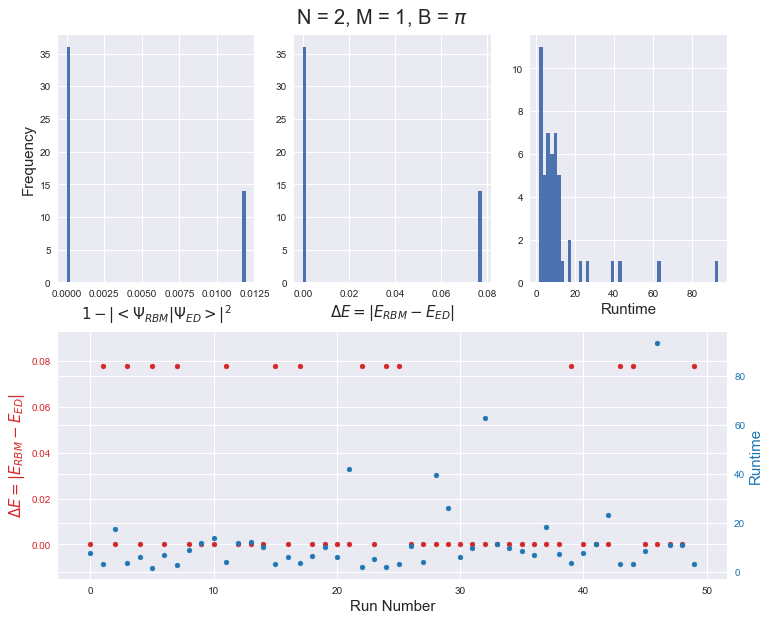

In [68]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 2, M = 1, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(M1stateErr, bins=50) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
M1counts, M1bins, M1bars = ax2.hist(M1engErr, bins=50) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(M1gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('$\Delta E = |E_{RBM}-E_{ED}|$', color=color,size = 15)
ax4.scatter(hisIt, M1engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, M1gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [108]:
smallError = 0
for i in range(50):
    if M1bins[i]<0.1:
        cutOff=i
for i in range(cutOff+1):
    smallError += M1counts[i]
successPer = smallError
print(successPer*2)

100.0


# Histogram N=2, M=2

In [70]:
#Parameter definition 
N= 2
M=2
B = np.pi
A0 = 1
M2gdResults = [] #gives ground state estimation at each iteration of gd
M2gdState = []
M2gdTime = []

M2edState = []
M2edTime = []

M2ActualEng = []
M2engErr = []
M2stateErr = []

hisIt = np.arange(50)

In [71]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    M2gdResults.append(gd)
    M2gdState.append(gd[0])
    M2gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    M2edState.append(ed[0])
    M2edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    M2ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    M2engErr.append(errTemp[0])
    M2stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -1.898453
         Iterations: 27
         Function evaluations: 1134
         Gradient evaluations: 63
Optimization terminated successfully.
         Current function value: -1.898448
         Iterations: 21
         Function evaluations: 1008
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -1.898447
         Iterations: 41
         Function evaluations: 1404
         Gradient evaluations: 78
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 16
         Function evaluations: 522
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -1.898453
         Iterations: 27
         Function evaluations: 1098
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: -1.820795
         Iterations: 5
         Function eval

Optimization terminated successfully.
         Current function value: -1.898453
         Iterations: 31
         Function evaluations: 1278
         Gradient evaluations: 71
Optimization terminated successfully.
         Current function value: -1.898446
         Iterations: 14
         Function evaluations: 630
         Gradient evaluations: 35


In [72]:
#Save data to JSON file
data = [M1gdTime,M1edTime,M1engErr,M1stateErr,len(hisIt)]
open("Data/Mar30/N2M2Bpi.json", "w").close()
with open('Data/Mar30/N2M2Bpi.json', 'a') as file:
    for item in data: 
        line = json.dumps(item)
        file.write(line + '\n')

<Figure size 576x396 with 0 Axes>

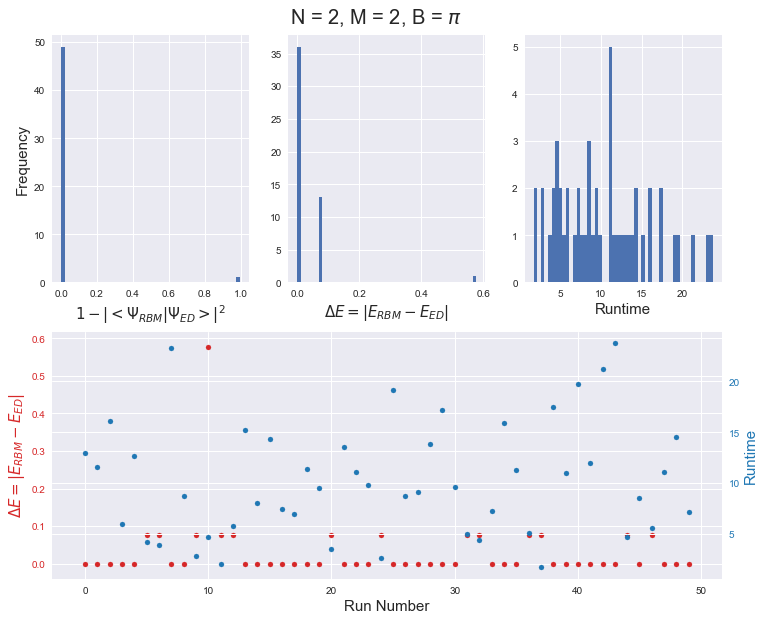

In [73]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 2, M = 2, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(M2stateErr, bins=50) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
M2counts, M2bins, M2bars = ax2.hist(M2engErr, bins=50) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(M2gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('$\Delta E = |E_{RBM}-E_{ED}|$', color=color,size = 15)
ax4.scatter(hisIt, M2engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, M2gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [107]:
smallError = 0
for i in range(50):
    if M2bins[i]<0.1:
        cutOff=i
for i in range(cutOff+1):
    smallError += M2counts[i]
successPer = smallError
print(successPer*2)

98.0


# Histogram N=2, M=3

In [75]:
#Parameter definition 
N=2
M=3
B = np.pi
A0 = 1
M3gdResults = [] #gives ground state estimation at each iteration of gd
M3gdState = []
M3gdTime = []

M3edState = []
M3edTime = []

M3ActualEng = []
M3engErr = []
M3stateErr = []

hisIt = np.arange(50)

In [76]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    M3gdResults.append(gd)
    M3gdState.append(gd[0])
    M3gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    M3edState.append(ed[0])
    M3edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    M3ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    M3engErr.append(errTemp[0])
    M3stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -1.898442
         Iterations: 37
         Function evaluations: 1752
         Gradient evaluations: 73
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 34
         Function evaluations: 1824
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: -1.898453
         Iterations: 29
         Function evaluations: 1344
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -1.898452
         Iterations: 22
         Function evaluations: 1536
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -1.898436
         Iterations: 19
         Function evaluations: 1272
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 29
         Function ev

Optimization terminated successfully.
         Current function value: -1.820757
         Iterations: 3
         Function evaluations: 264
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 19
         Function evaluations: 744
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: -1.898452
         Iterations: 22
         Function evaluations: 960
         Gradient evaluations: 40


In [77]:
#Save data to JSON file
data = [M1gdTime,M1edTime,M1engErr,M1stateErr,len(hisIt)]
open("Data/Mar30/N2M3Bpi.json", "w").close()
with open('Data/Mar30/N2M3Bpi.json', 'a') as file:
    for item in data: 
        line = json.dumps(item)
        file.write(line + '\n')

<Figure size 576x396 with 0 Axes>

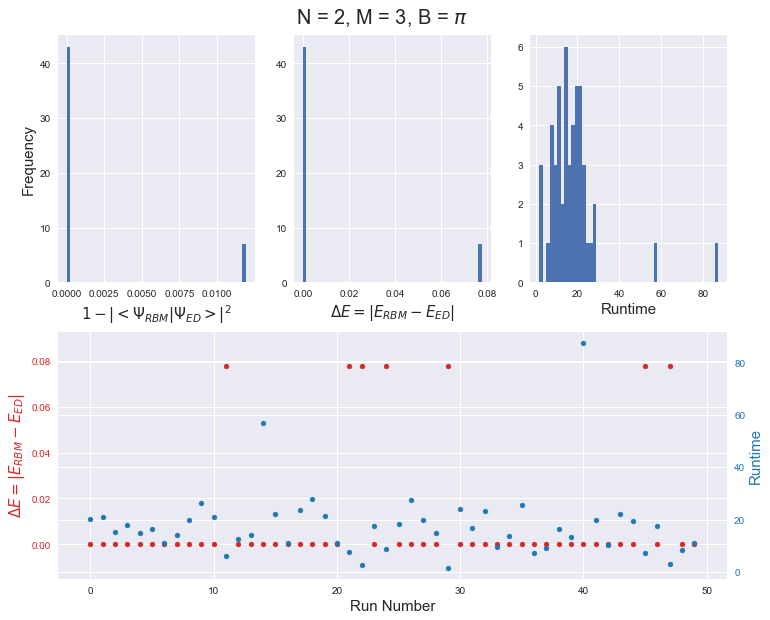

In [101]:
#RERUNNN
plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 2, M = 3, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(M3stateErr, bins=50) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
M3counts, M3bins, M3bars = ax2.hist(M3engErr, bins=50) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(M3gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('$\Delta E = |E_{RBM}-E_{ED}|$', color=color,size = 15)
ax4.scatter(hisIt, M3engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, M3gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [103]:
smallError = 0
for i in range(50):
    if M3bins[i]<0.1:
        cutOff=i
print(cutOff)

for i in range(cutOff+1):
    smallError += M3counts[i]
successPer = smallError
print(successPer*2)

49
100.0


# Histogram N=3, M=1

In [80]:
#Parameter definition 
N= 3
M=1
B = np.pi
A0 = 1
N3M1gdResults = [] #gives ground state estimation at each iteration of gd
N3M1gdState = []
N3M1gdTime = []

N3M1edState = []
N3M1edTime = []

N3M1ActualEng = []
N3M1engErr = []
N3M1stateErr = []

hisIt = np.arange(50)

In [81]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    N3M1gdResults.append(gd)
    N3M1gdState.append(gd[0])
    N3M1gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    N3M1edState.append(ed[0])
    N3M1edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    N3M1ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    N3M1engErr.append(errTemp[0])
    N3M1stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -2.203183
         Iterations: 177
         Function evaluations: 7040
         Gradient evaluations: 440
Optimization terminated successfully.
         Current function value: -2.203185
         Iterations: 274
         Function evaluations: 11312
         Gradient evaluations: 707
Optimization terminated successfully.
         Current function value: -2.203216
         Iterations: 249
         Function evaluations: 9840
         Gradient evaluations: 615
Optimization terminated successfully.
         Current function value: -2.203183
         Iterations: 153
         Function evaluations: 6288
         Gradient evaluations: 393
Optimization terminated successfully.
         Current function value: -2.203179
         Iterations: 183
         Function evaluations: 7392
         Gradient evaluations: 462
Optimization terminated successfully.
         Current function value: -2.203211
         Iterations: 168
        

Optimization terminated successfully.
         Current function value: -2.203186
         Iterations: 230
         Function evaluations: 9248
         Gradient evaluations: 578
Optimization terminated successfully.
         Current function value: -2.070745
         Iterations: 5
         Function evaluations: 272
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: -2.203193
         Iterations: 142
         Function evaluations: 5408
         Gradient evaluations: 338


In [82]:
#Save data to JSON file
data = [M1gdTime,M1edTime,M1engErr,M1stateErr,len(hisIt)]
open("Data/Mar30/N3M1Bpi.json", "w").close()
with open('Data/Mar30/N3M1Bpi.json', 'a') as file:
    for item in data: 
        line = json.dumps(item)
        file.write(line + '\n')

<Figure size 576x396 with 0 Axes>

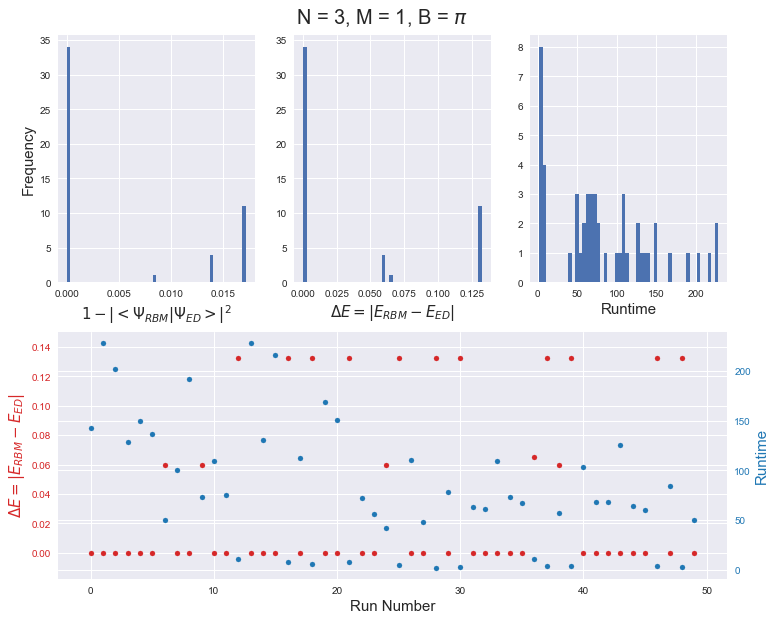

In [83]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 3, M = 1, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(N3M1stateErr, bins=50) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
N3M1counts, N3M1bins, N3M1bars = ax2.hist(N3M1engErr, bins=50) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(N3M1gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('$\Delta E = |E_{RBM}-E_{ED}|$', color=color,size = 15)
ax4.scatter(hisIt, N3M1engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, N3M1gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [104]:
smallError = 0
for i in range(50):
    if N3M1bins[i]<0.1:
        cutOff=i
smallError=0        
for i in range(cutOff+1):
    smallError += N3M1counts[i]
successPer = smallError
print(successPer*2)

78.0


# Histogram N=3, M=2

In [85]:
#Parameter definition 
N= 3
M=2
B = np.pi
A0 = 1
N3M2gdResults = [] #gives ground state estimation at each iteration of gd
N3M2gdState = []
N3M2gdTime = []

N3M2edState = []
N3M2edTime = []

N3M2ActualEng = []
N3M2engErr = []
N3M2stateErr = []

hisIt = np.arange(50)

In [86]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    N3M2gdResults.append(gd)
    N3M2gdState.append(gd[0])
    N3M2gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    N3M2edState.append(ed[0])
    N3M2edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    N3M2ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    N3M2engErr.append(errTemp[0])
    N3M2stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -2.070756
         Iterations: 5
         Function evaluations: 456
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: -2.070753
         Iterations: 7
         Function evaluations: 624
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -2.203187
         Iterations: 187
         Function evaluations: 11112
         Gradient evaluations: 463
Optimization terminated successfully.
         Current function value: -2.203254
         Iterations: 149
         Function evaluations: 8376
         Gradient evaluations: 349
Optimization terminated successfully.
         Current function value: -2.070780
         Iterations: 20
         Function evaluations: 1248
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: -2.070736
         Iterations: 7
         Function ev

Optimization terminated successfully.
         Current function value: -2.138204
         Iterations: 51
         Function evaluations: 2736
         Gradient evaluations: 114
Optimization terminated successfully.
         Current function value: -2.203223
         Iterations: 213
         Function evaluations: 12096
         Gradient evaluations: 504
Optimization terminated successfully.
         Current function value: -2.203213
         Iterations: 179
         Function evaluations: 10536
         Gradient evaluations: 439


In [87]:
#Save data to JSON file
data = [M1gdTime,M1edTime,M1engErr,M1stateErr,len(hisIt)]
open("Data/Mar30/N3M2Bpi.json", "w").close()
with open('Data/Mar30/N3M2Bpi.json', 'a') as file:
    for item in data: 
        line = json.dumps(item)
        file.write(line + '\n')

<Figure size 576x396 with 0 Axes>

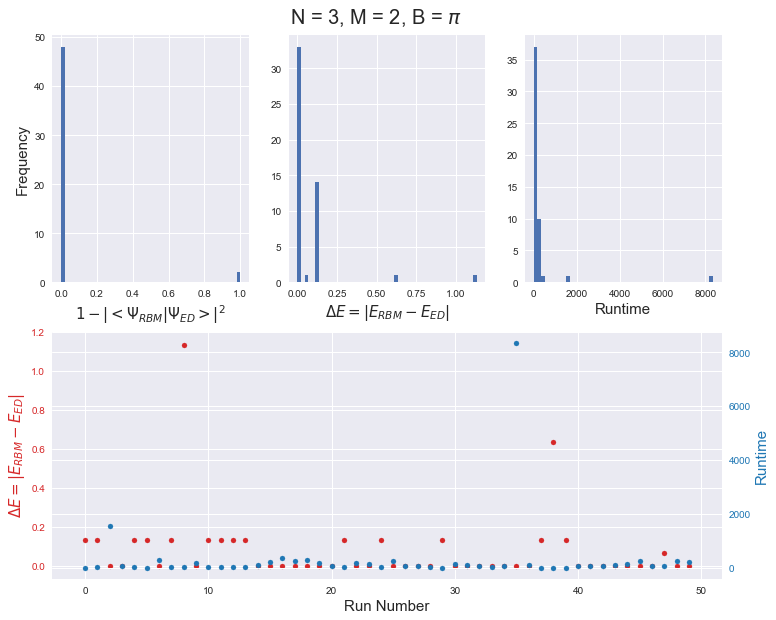

In [88]:

plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 3, M = 2, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(N3M2stateErr, bins=50) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
N3M2counts, N3M2bins, N3M1bars = ax2.hist(N3M2engErr, bins=50) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(N3M2gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('$\Delta E = |E_{RBM}-E_{ED}|$', color=color,size = 15)
ax4.scatter(hisIt, N3M2engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisIt, N3M2gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)



In [105]:
smallError = 0
for i in range(50):
    if N3M2bins[i]<0.1:
        cutOff=i
smallError=0
for i in range(cutOff+1):
    smallError += N3M2counts[i]
successPer = smallError
print(successPer*2)

68.0


# Histogram N=3, M=3

In [90]:
#Parameter definition 
N= 3
M=3
B = np.pi
A0 = 1
N3M3gdResults = [] #gives ground state estimation at each iteration of gd
N3M3gdState = []
N3M3gdTime = []

N3M3edState = []
N3M3edTime = []

N3M3ActualEng = []
N3M3engErr = []
N3M3stateErr = []

hisItShort = np.arange(50)

In [91]:
for i in range(len(hisItShort)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    N3M3gdResults.append(gd)
    N3M3gdState.append(gd[0])
    N3M3gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    N3M3edState.append(ed[0])
    N3M3edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    N3M3ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    N3M3engErr.append(errTemp[0])
    N3M3stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -2.203246
         Iterations: 96
         Function evaluations: 7040
         Gradient evaluations: 220
Optimization terminated successfully.
         Current function value: -2.203251
         Iterations: 141
         Function evaluations: 8224
         Gradient evaluations: 257
Optimization terminated successfully.
         Current function value: -2.203263
         Iterations: 97
         Function evaluations: 5600
         Gradient evaluations: 175
Optimization terminated successfully.
         Current function value: -2.203257
         Iterations: 144
         Function evaluations: 11104
         Gradient evaluations: 347
Optimization terminated successfully.
         Current function value: -2.070795
         Iterations: 6
         Function evaluations: 640
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -2.203264
         Iterations: 55
         Functi

Optimization terminated successfully.
         Current function value: -2.203278
         Iterations: 77
         Function evaluations: 5312
         Gradient evaluations: 166
Optimization terminated successfully.
         Current function value: -2.203242
         Iterations: 108
         Function evaluations: 7808
         Gradient evaluations: 244
Optimization terminated successfully.
         Current function value: -2.070752
         Iterations: 7
         Function evaluations: 800
         Gradient evaluations: 25


In [92]:
#Save data to JSON file
data = [M1gdTime,M1edTime,M1engErr,M1stateErr,len(hisIt)]
open("Data/Mar30/N3M3Bpi.json", "w").close()
with open('Data/Mar30/N3M3Bpi.json', 'a') as file:
    for item in data: 
        line = json.dumps(item)
        file.write(line + '\n')

<Figure size 576x396 with 0 Axes>

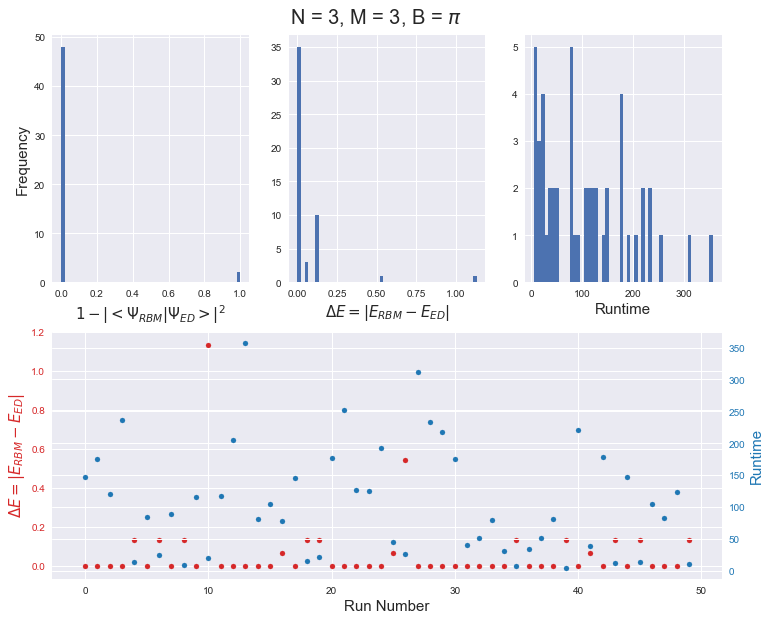

In [93]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(12,10))
ttl = plt.suptitle("N = 3, M = 3, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=2)
ttl.set_position([.5, 0.92])

ax1 = plt.subplot(gs[0, 0])
ax1 .hist(N3M3stateErr, bins=50) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1 .set_ylabel("Frequency", size = 15)

ax2 = plt.subplot(gs[0, 1])
N3M3counts, N3M3bins, N3M3bars = ax2.hist(N3M3engErr, bins=50) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)


ax3 = plt.subplot(gs[0, 2])
ax3.hist(N3M3gdTime, bins=50) 
ax3.set_xlabel("Runtime",size = 15)



ax4 = plt.subplot(gs[1, :])
color = 'tab:red'
ax4.set_xlabel('Run Number',size = 15)
ax4.set_ylabel('$\Delta E = |E_{RBM}-E_{ED}|$', color=color,size = 15)
ax4.scatter(hisItShort, N3M3engErr,color=color, s=25)
ax4.tick_params(axis='y', labelcolor=color)

ax5 = ax4.twinx()  
color = 'tab:blue'
ax5.set_ylabel('Runtime', color=color,size = 15)  
ax5.scatter(hisItShort, N3M3gdTime, color=color, s=25)
ax5.tick_params(axis='y', labelcolor=color)





In [106]:
smallError = 0
for i in range(50):
    if N3M3bins[i]<0.1:
        cutOff=i
smallError=0
for i in range(cutOff+1):
    smallError += N3M3counts[i]
successPer = smallError
print(successPer*2)

76.0
